# Diamond price predictor (Python)

Quick notebook assessing the price of diamonds based on a number of different inputs. In the interest of practice, wanted to give this a crack from scratch without reference to the starter code. Have also done this in Python (again for practice) but have avoided functions that would not be possible in R as discussed so far in class.

Predictions are made on the basis of linear regression using multiple variables in the main body of the notebook. Towards the end, a neural network approach is implemented as an alternative option. Graphing the linear view reveals limitations in the model that appear to be at least partially solved through a relatively shallow neural network. However, this approach was not submitted to the board.

The naive linear regression appoach, assuming no specifically correlated variables, delivered relatively poor performance (~30 MAPE), also projecting many diamonds to have negative values. The neural network approach provided a much better prediction, staying fairly accurate at high prices and giving an overall MAPE (on the validation set) of ~8. 

In [18]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
from numpy.random import RandomState
import pandas as pd

df = pd.read_csv('data.csv')
rng = RandomState()

train = df.sample(frac=0.8, random_state=rng)
test = df.loc[~df.index.isin(train.index)]

train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [62]:
df = pd.read_csv("train.csv")
df.head()

,Id,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,3399,1.34,Very Good,H,SI1,G,VG,GIA,7655
1,5869,1.00,Very Good,G,VS2,EX,VG,GIA,7743
2,4009,0.80,Ideal,G,VS2,VG,VG,GIA,3314
3,4988,1.28,Ideal,G,VVS2,VG,EX,GIA,10635
4,273,1.20,Very Good,F,VS1,VG,VG,GIA,9574


In [63]:
df_test = pd.read_csv("test.csv")
df_test.head()

,Id,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
1,10,0.91,Ideal,D,VS2,VG,VG,GIA,6224
2,17,1.28,Very Good,I,VS1,EX,VG,GIA,6726
3,26,2.02,Very Good,I,SI1,G,G,GIA,14839
4,28,2.41,Very Good,H,VS2,EX,EX,GIA,27337


# Basic data visualization

In order to get a rough sense of how the price is distributed, we do a distplot (Kaggle seaborn version is apparently 0.10.0, meaning displot is not implemented)

C:\Users\User\AppData\Local\Temp\ipykernel_1548\834922981.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Price'])


<Axes: xlabel='Price', ylabel='Density'>

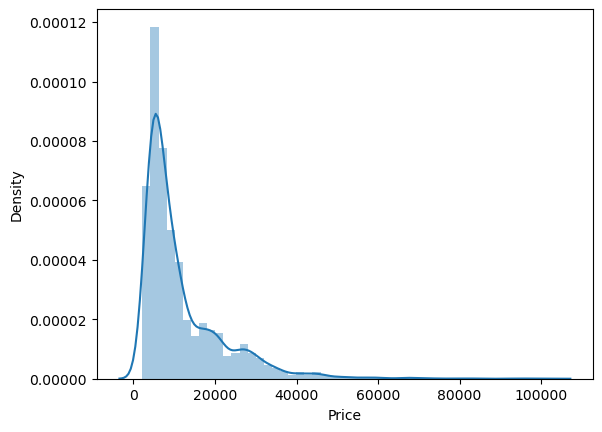

In [64]:
sns.distplot(df['Price'])

C:\Users\User\AppData\Local\Temp\ipykernel_1548\4088346702.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Carat Weight'])


<Axes: xlabel='Carat Weight', ylabel='Density'>

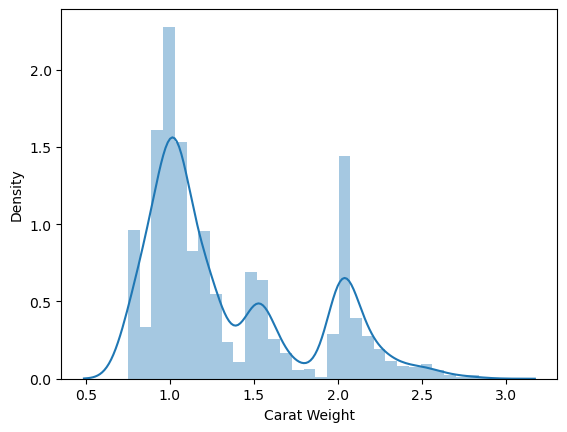

In [65]:
sns.distplot(df['Carat Weight'])

# Mapping of ordinal variables

The variables Polish, Clarity, Cut, Color and Symmetry and ordered categorical variables, so we will use mappings to determine the values

In [66]:
polish_map = {'G': 1, 
              'VG': 2, 
              'EX': 3, 
              'ID': 4}

In [67]:
clarity_map = {'SI1': 1, 
               'VS2': 2, 
               'VS1': 3,
               'VVS2': 4,
               'VVS1': 5,
               'IF': 6,
               'FL': 7}

In [68]:
symmetry_map = {'G': 1,
                'VG': 2,
                'EX': 3,
                'ID': 4}

In [69]:
color_map = {'J': 1,
                'I': 2,
                'H': 3,
                'G': 4,
                'F': 5,
                'E': 6,
                'D': 7}

In [70]:
cut_map = {'Poor': 1, 
               'Fair': 2, 
               'Good': 3,
               'Very Good': 4,
               'Ideal': 5,
               'Signature-Ideal': 6}

In [71]:
df['Cut'] = df['Cut'].map(cut_map)
df['Color'] = df['Color'].map(color_map)
df['Polish'] = df['Polish'].map(polish_map)
df['Symmetry'] = df['Symmetry'].map(symmetry_map)
df['Clarity'] = df['Clarity'].map(clarity_map)

In [72]:
df_test['Cut'] = df_test['Cut'].map(cut_map)
df_test['Color'] = df_test['Color'].map(color_map)
df_test['Polish'] = df_test['Polish'].map(polish_map)
df_test['Symmetry'] = df_test['Symmetry'].map(symmetry_map)
df_test['Clarity'] = df_test['Clarity'].map(clarity_map)

# Using dummy variables
 
The report seems unlikely to drive meaningful difference, but in the absence of a data dictionary definition we will use it in case there is a material difference in how different industry reports are perceived

In [73]:
df = pd.get_dummies(df, drop_first=True)
df_test = pd.get_dummies(df_test, drop_first=True)

df.head()

,Id,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Price,Report_GIA
0,3399,1.34,4,3,1,1,2,7655,1
1,5869,1.00,4,4,2,3,2,7743,1
2,4009,0.80,5,4,2,2,2,3314,1
3,4988,1.28,5,4,4,2,3,10635,1
4,273,1.20,4,5,3,2,2,9574,1


# Using logarithms for price

In [74]:
df['Price'] = np.log(df['Price'])

# Dividing up the data


In [75]:
df_X = df.drop(['Price', 'Id'], axis=1)
df_y = df['Price']

In [94]:
X_train, X_valid, y_train, y_valid = train_test_split(df_X, df_y, test_size=0.2)
X_test = df_test.drop(['Price', 'Id'], axis=1)
y_test= df_test['Price']

# Simple linear regression

In [78]:
lm = LinearRegression()
lm.fit(X_train, y_train)

predictions = lm.predict(X_valid)

Text(0, 0.5, 'Predicted Y')

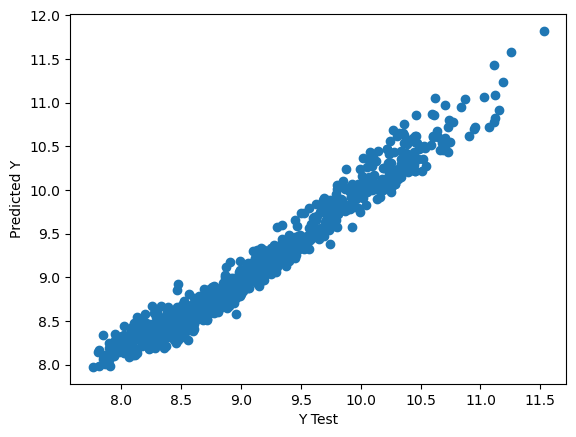

In [79]:
plt.scatter(y_valid,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [80]:
mean_squared_error(y_valid, predictions)

0.021168746616157703

In [81]:
np.sqrt(mean_squared_error(y_valid, predictions) / 1200)

0.004200074068410154

In [82]:
# MAPE

np.mean(np.abs((y_valid - predictions) / y_valid)) * 100

1.2808603651713995

# Adding Polynomial features

In [83]:
X_valid.shape

(960, 7)

In [84]:
X_test.shape

(1200, 7)

In [86]:
poly_features = PolynomialFeatures(degree=3, include_bias=False)

X_train_poly = poly_features.fit_transform(X_train)
X_valid_poly = poly_features.transform(X_valid)
X_test_poly = poly_features.transform(X_test)

In [87]:
lm_poly = LinearRegression()

In [88]:
lm_poly.fit(X_train_poly, y_train)

predictions_poly = lm_poly.predict(X_valid_poly)

Text(0, 0.5, 'Predicted Y')

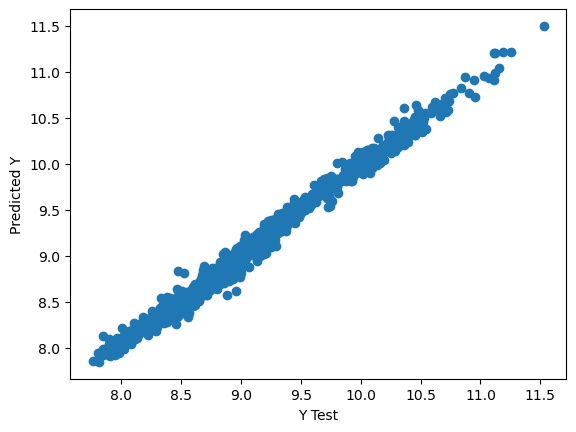

In [89]:
plt.scatter(y_valid,predictions_poly)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [90]:
# MAPE

np.mean(np.abs((y_valid - predictions_poly) / y_valid)) * 100

0.6963467838204798

In [100]:
mean_squared_error(y_valid, predictions)

1.0754416204646486

In [101]:
np.sqrt(mean_squared_error(y_valid, predictions) / 1200)

0.029936622227419166

# Neural Network Approach

The predictions do not look totally unreasoanble using the linear regression approach. However, it is evident that the model is not doing a good job of predicting the most expensive diamonds, indicating that there may be more complex relationships at play than pure linear coefficients. As such, we can use a simple neural network in order to try and understand some of the more nuanced relationships. Note this could have been done using linear combinations of variables, but with no domain knowledge, I consider this approach more straightforward (especially since we are looking to predict, not to explain relationships) 

In [92]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

In [93]:
scaler = StandardScaler()

X_train_nn = scaler.fit_transform(X_train)
X_valid_nn = scaler.transform(X_valid)
X_test_nn = scaler.transform(X_test)

In [54]:
model = keras.models.Sequential([
    keras.layers.Dense(28, activation = 'relu'),
    keras.layers.Dense(28, activation = 'relu'), 
    keras.layers.Dense(14, activation = 'relu'),
    keras.layers.Dense(7, activation = 'relu'),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="adam")

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [55]:
model.fit(X_train_nn, y_train, epochs=200, validation_data=(X_valid_nn, y_valid), callbacks=[early_stopping_cb])

Epoch 1/200
150/150 [==============================] - 2s 4ms/step - loss: 25.5233 - val_loss: 2.4311
Epoch 2/200
150/150 [==============================] - 0s 3ms/step - loss: 1.8909 - val_loss: 1.5354
Epoch 3/200
150/150 [==============================] - 0s 2ms/step - loss: 1.2886 - val_loss: 1.0628
Epoch 4/200
150/150 [==============================] - 0s 2ms/step - loss: 0.8796 - val_loss: 0.6993
Epoch 5/200
150/150 [==============================] - 0s 3ms/step - loss: 0.5622 - val_loss: 0.4375
Epoch 6/200
150/150 [==============================] - 0s 2ms/step - loss: 0.3345 - val_loss: 0.2515
Epoch 7/200
150/150 [==============================] - 0s 3ms/step - loss: 0.1843 - val_loss: 0.1394
Epoch 8/200
150/150 [==============================] - 0s 2ms/step - loss: 0.1022 - val_loss: 0.0857
Epoch 9/200
150/150 [==============================] - 0s 2ms/step - loss: 0.0627 - val_loss: 0.0599
Epoch 10/200
150/150 [==============================] - 0s 3ms/step - loss: 0.0450 - val_l

38/38 [==============================] - 0s 2ms/step


Text(0, 0.5, 'Predicted Y')

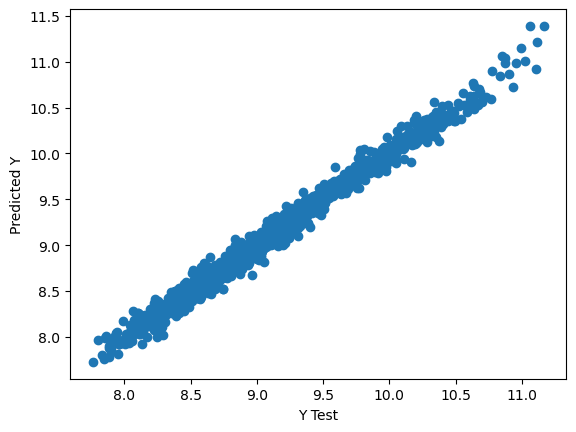

In [56]:
predictions_nn = model.predict(X_valid_nn)

plt.scatter(y_valid,predictions_nn)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [57]:
mean_squared_error(y_valid, predictions_nn)

0.006549411149365739

In [58]:
np.sqrt(mean_squared_error(y_valid, predictions_nn) / 1200)

0.0023362026077529

In [59]:
predictions_nn.ravel().shape

(1200,)

In [60]:
# MAPE

np.mean(np.abs((y_valid - predictions_nn.ravel()) / y_valid)) * 100

0.6828382572140803

# Outputting predictions as csv file for download

In [39]:
test_predictions = np.exp(lm.predict(X_test))
test_predictions_nn = np.exp(model.predict(X_test))

test_predictions_poly = np.exp(lm_poly.predict(X_test_poly))

ensemble_predictions = (test_predictions_nn + test_predictions_poly) / 2

preds = {'lm':test_predictions, 'nn':test_predictions_nn, 'poly_lm': test_predictions_poly, 'ensemble': ensemble_predictions}

In [99]:
X_test

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report_GIA
0,0.83,5,3,3,4,4,0
1,0.91,5,7,2,2,2,1
2,1.28,4,2,3,3,2,1
3,2.02,4,2,1,1,1,1
4,2.41,4,3,2,3,3,1
...,...,...,...,...,...,...,...
1195,1.02,4,7,1,3,3,1
1196,1.00,3,6,1,3,3,1
1197,0.90,3,3,1,2,2,1
1198,2.43,5,2,6,3,2,1


In [40]:
result_set = 'poly_lm'
df_test['Price'] = preds[result_set]
df_test[['ID', 'Price']]

,ID,Price
0,6001,17180.951072
1,6002,48309.704968
2,6003,3756.798872
3,6004,23253.722164
4,6005,16651.889129
...,...,...
3137,9138,5041.616482
3138,9139,9099.553077
3139,9140,9601.239760
3140,9141,7707.083617


In [41]:
df_test[['ID', 'Price']].to_csv('out.csv', index=False)